In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch

from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

/tmp/ipykernel_149537/3956026877.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-22 15:42:23.563987: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-22 15:42:23.603319: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-22 15:4

In [2]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so let's set default device to GPU
    torch.set_default_device(0)
    print("CUDA is available. Using GPU.")
else:
    # CUDA is not available, so let's use the CPU
    print("CUDA is not available. Using CPU.")

# Example usage:
tensor = torch.randn(3, 3)  # Create a tensor on the selected device
print("Tensor is on device:", tensor.device)


CUDA is available. Using GPU.
Tensor is on device: cuda:0


In [3]:
channel_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06','Cloud_B07',
                 'Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13']

data_water=parse.parse('cloudrm_water.dat')
data_clear=parse.parse('cloudrm_clear.dat')
data_ice=parse.parse('cloudrm_ice.dat')
data_mixed=parse.parse('cloudrm_mixed.dat')

#Concatinate all datasets
data_all=pd.concat([data_water, data_clear, data_ice, data_mixed])
data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])
df_truth=data_all.copy()

#data_all=hf.add_MSI_noise(data_all,channel_labels)

In [4]:
##Train test validation split##
X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13',
           'Sat_Zenith_Angle','Sun_Zenith_Angle','Azimuth_Diff_Angle']

#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.
y_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05','Clear_B06',
           'Clear_B07','Clear_B08','Clear_B09','Clear_B10','Clear_B11','Clear_B12','Clear_B13']

X_truth=df_truth[X_labels]

df=data_all.copy()
#df=hf.normalise_input_df(data_all,X_labels)
#df=hf.add_noise(df,X_labels,sigma=0.001)

##Split data##
X=df[X_labels]
y=df[y_labels]

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.05)

X_test_truth=X_truth.iloc[X_test.index] #Save truth values without normalisation

In [5]:
import random

val_size=0.05
validation_indices=np.array(random.sample(range(len(X_train['Cloud_B02'])), int(len(X_train['Cloud_B02'])*val_size)))
train_indices=[i for i in range(len(X_train['Cloud_B02'])) if np.any(validation_indices==i)==False]

quantiles=np.array([0.1,0.5,0.9])
batch_size=500

In [6]:
nepochs=10

model=QuantileNetwork(quantiles=quantiles)

# Add everything but the output layer
sequence=nn.Sequential(
    nn.Linear(len(X_labels),128),
    nn.ReLU(),
    nn.Linear(128,128),
    nn.ReLU(),
    nn.Linear(128, len(quantiles)*len(y_labels)) #Output dimesion is number of quantiles times number of target variables
)
model.fit(X_train.to_numpy(),y_train.to_numpy(), 
          train_indices, 
          validation_indices, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequence,
          lr=0.003,
          data_norm=True)

Epoch 1


/home/edgelab/.local/lib/python3.10/site-packages/torch/utils/_device.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
Batch number: 100%|██████████| 361/361 [00:01<00:00, 286.56it/s]

Training loss [3.0131638] Validation loss [2.2772663]
----New best validation loss---- [2.2772663]
Epoch 2



Batch number: 100%|██████████| 361/361 [00:00<00:00, 521.82it/s]

Training loss [2.198154] Validation loss [2.097632]
----New best validation loss---- [2.097632]
Epoch 3



Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.22it/s]

Training loss [2.0738993] Validation loss [2.0456614]
----New best validation loss---- [2.0456614]
Epoch 4



Batch number: 100%|██████████| 361/361 [00:00<00:00, 381.81it/s]

Training loss [2.0153615] Validation loss [1.9823098]
----New best validation loss---- [1.9823098]
Epoch 5



Batch number: 100%|██████████| 361/361 [00:01<00:00, 347.68it/s]

Training loss [1.9733156] Validation loss [1.9525644]
----New best validation loss---- [1.9525644]
Epoch 6



Batch number: 100%|██████████| 361/361 [00:01<00:00, 355.74it/s]


Training loss [1.9393543] Validation loss [1.9104346]
----New best validation loss---- [1.9104346]
Epoch 7


Batch number: 100%|██████████| 361/361 [00:00<00:00, 363.35it/s]

Training loss [1.9087226] Validation loss [1.8891416]
----New best validation loss---- [1.8891416]
Epoch 8



Batch number: 100%|██████████| 361/361 [00:00<00:00, 451.85it/s]

Training loss [1.8889214] Validation loss [1.8862164]


----New best validation loss---- [1.8862164]
Epoch 9


Batch number: 100%|██████████| 361/361 [00:00<00:00, 509.07it/s]

Training loss [1.8747486] Validation loss [1.8636225]
----New best validation loss---- [1.8636225]
Epoch 10



Batch number: 100%|██████████| 361/361 [00:00<00:00, 371.43it/s]

Training loss [1.8608661] Validation loss [1.837778]
----New best validation loss---- [1.837778]
Best model out of total max epochs found at epoch 10


In [7]:
preds = model.predict(X_test.to_numpy())
mse=mean_squared_error(y_test.to_numpy(),preds[:,:,1])
psnr=QuantileNetwork.PSNR(y_test,preds[:,:,1])
outrate=QuantileNetwork.calc_outrate(y_test.to_numpy(),preds)
r2=r2_score(y_test.to_numpy(),preds[:,:,1])

In [17]:
print("MSE: "+str(mse))
print("PSNR: "+str(psnr))
print("Outrate: "+str(outrate))
print("R2 score: "+str(r2))

MSE: 0.005425489499028019
PSNR: 27.373762625555102
Outrate: 0.12808333333333333
R2 score: 0.9235031841994754


In [18]:
model_metrics=pd.DataFrame(data=[[mse,psnr,r2,outrate]],columns=['MSE','PSNR','R2_score','Outrate'])
model_metrics

,MSE,PSNR,R2_score,Outrate
0,0.005425,27.373763,0.923503,0.128083


In [19]:
model_metrics_2=pd.DataFrame(data=[[mse,psnr,r2,outrate]],columns=['MSE','PSNR','R2_score','Outrate'])

In [20]:
model_cat=pd.concat([model_metrics,model_metrics_2])
model_cat=model_cat.reset_index(drop=True)
model_cat

,MSE,PSNR,R2_score,Outrate
0,0.005425,27.373763,0.923503,0.128083
1,0.005425,27.373763,0.923503,0.128083


## Visualise

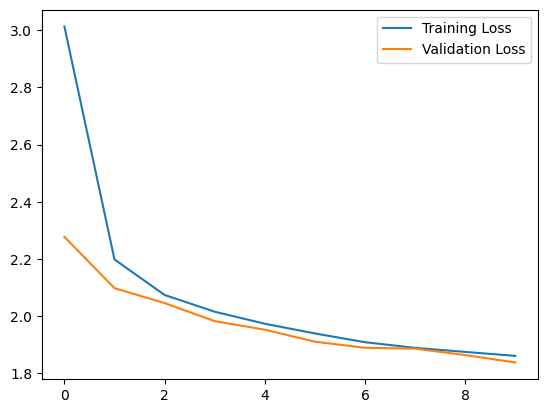

In [21]:
plt.plot(model.train_loss.data.cpu().numpy())
plt.plot(model.val_loss.data.cpu().numpy())
plt.legend(['Training Loss','Validation Loss'])

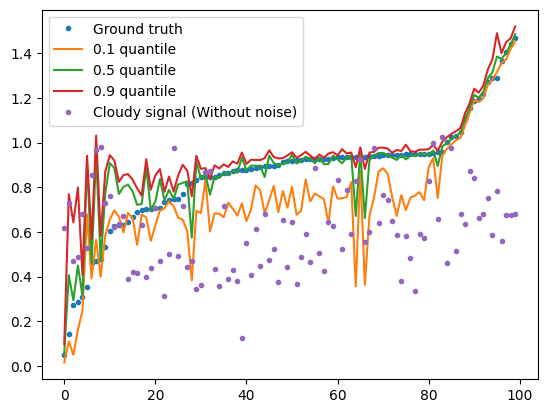

In [22]:
samples=100
channel=10

#Get ground truth y
y_plot=y_test.to_numpy()[:,channel]
y_plot=y_plot[0:samples]
sort_ind=np.argsort(y_plot)
y_plot_sort=y_plot[sort_ind]

#Get y predictions
y_pred=preds[:,channel,:]
y_pred=y_pred[0:samples,:]
y_pred_sort=y_pred[sort_ind,:]

# Get cloudy signal
cloudy=X_test_truth.to_numpy()[:,channel]
cloudy=cloudy[0:samples]
cloudy_sort=cloudy[sort_ind]

plt.plot(y_plot_sort,'.')
plt.plot(y_pred_sort)
plt.plot(cloudy_sort,'.')
plt.legend(['Ground truth','0.1 quantile', '0.5 quantile','0.9 quantile','Cloudy signal (Without noise)'])
plt.show()


/tmp/ipykernel_149537/2806638512.py:22: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.errorbar(x=np.linspace(0,samples,samples)


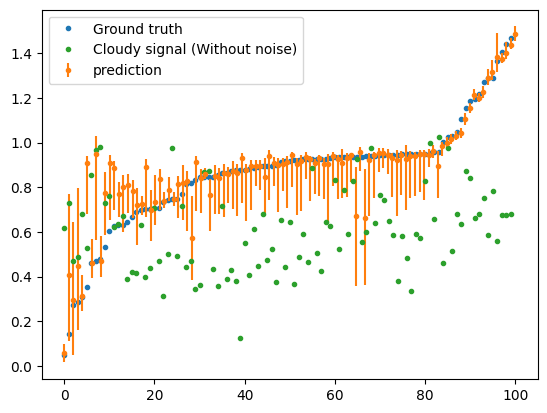

In [23]:
samples=100
channel=10

#Get ground truth y
y_plot=y_test.to_numpy()[:,channel]
y_plot=y_plot[0:samples]
sort_ind=np.argsort(y_plot)
y_plot_sort=y_plot[sort_ind]

#Get y predictions
y_pred=preds[:,channel,:]
y_pred=y_pred[0:samples,:]
y_pred_sort=y_pred[sort_ind,:]

# Get cloudy signal
cloudy=X_test_truth.to_numpy()[:,channel]
cloudy=cloudy[0:samples]
cloudy_sort=cloudy[sort_ind]


plt.plot(y_plot_sort,'.')
plt.errorbar(x=np.linspace(0,samples,samples)
             ,y=y_pred_sort[:,1],
             yerr=[np.abs(y_pred_sort[:,1]-y_pred_sort[:,0]),np.abs(y_pred_sort[:,1]-y_pred_sort[:,2])],
             marker='.',fmt='.')
plt.plot(cloudy_sort,'.')
plt.legend(['Ground truth','Cloudy signal (Without noise)','prediction'])
plt.show()

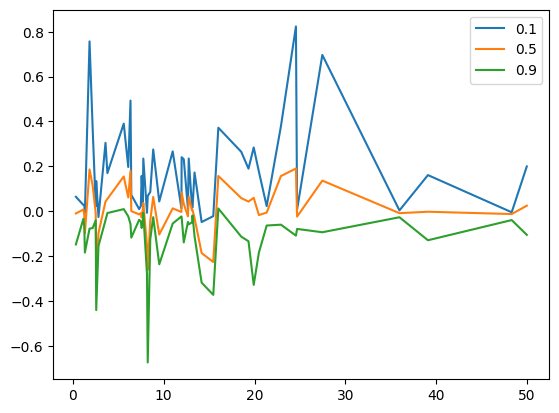

In [24]:
channel=11
samples=50

df_test=df.iloc[y_test.index]

#Get cot values
cot_column=df_test['COT'].to_numpy()
cot_column=cot_column[0:samples]
sort_ind=np.argsort(cot_column)
cot_column_sort=cot_column[sort_ind]

#Get ground truth
y_plot=y_test.to_numpy()[:,channel]
y_plot=y_plot[0:samples]
y_plot_sort=y_plot[sort_ind]

#Get y predictions
y_pred=preds[:,channel,:]
y_pred=y_pred[0:samples,:]
y_pred_sort=y_pred[sort_ind,:]

#Repeat ground truth to prepp difference
y_rep=np.repeat(y_plot_sort,len(quantiles),axis=0)
y_rep=np.reshape(y_rep,(-1,len(quantiles)))
diff=y_rep-y_pred_sort

#plt.plot(cot_column_sort,y_plot_sort,'.')
#plt.plot(cot_column_sort,y_pred_sort,'.')
plt.plot(cot_column_sort,diff)
plt.legend(['0.1','0.5','0.9'])

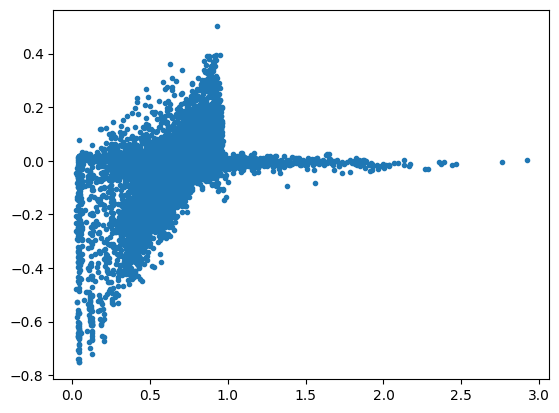

In [26]:
## Residual graph for channel 11
channel=11

y_11=y_test.to_numpy()[:,channel]
y_pred=preds[:,channel,:]

res=y_11-y_pred[:,1]

plt.plot(y_11,res,'.')


In [ ]:
hf.save_model_and_test_data(filepath='pytorch_models/'+str(nepochs)+'epochs',model=model,X_test=X_test,y_test=y_test)